# Understanding sources of uncertainty for baseline crossing


In this notebook we aim at investigating the sources of uncertainty for the RBP process. In particular, we estimate the sources of uncertainty to be: 
 
1. `rb_onboard_power`
2. `renewal_rate`
3. `fil_plus_rate`
4. `duration`


Given this, we aim at estimating the probability distribution for these quantities. We begin by importing the required libraries. 

In [7]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from getRenewalData import getRenewalData
import matplotlib
import matplotlib.dates as mdates
from scipy import stats
import datetime


font = {'size'   : 28,
        'family':'serif'}

matplotlib.rc('font', **font)
START_DATE='2022-01-01'
df_ren=getRenewalData(START_DATE)

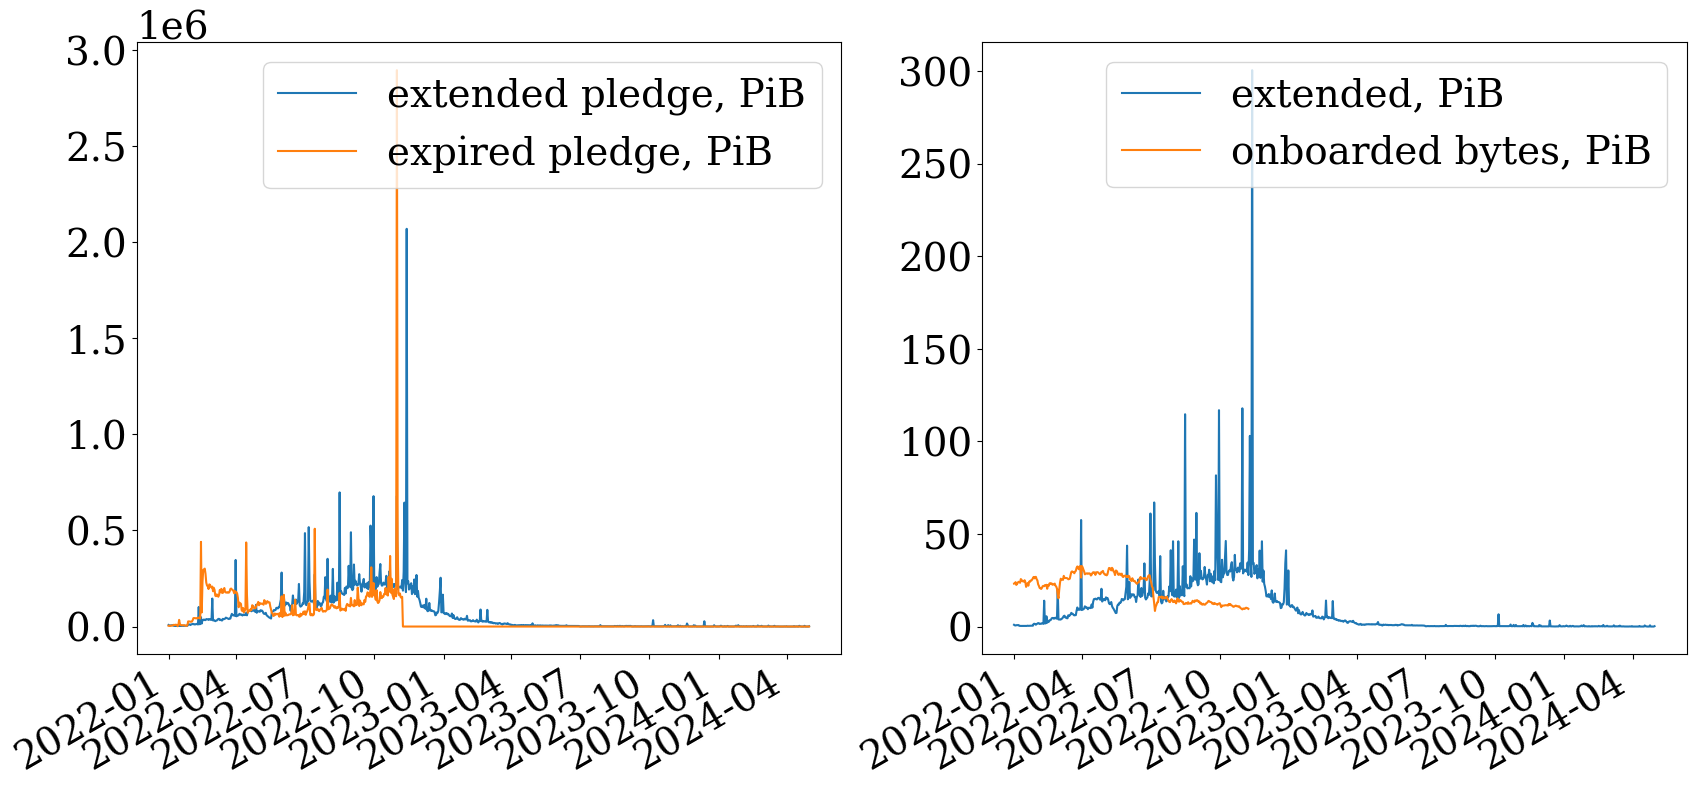

In [8]:
fig,ax=plt.subplots(1,2,figsize=(20,9))
ax[0].plot(df_ren['extended_pledge'],label='extended pledge, PiB')
ax[0].plot(df_ren['expired_pledge'],label='expired pledge, PiB')
ax[0].legend()
fig.autofmt_xdate()

ax[1].plot(df_ren['extended_bytes'],label='extended, PiB')
ax[1].plot(df_ren['onboarded_bytes'],label='onboarded bytes, PiB')
ax[1].legend()
fig.autofmt_xdate()


## Onboarding

We begin by investigating the dynamics for the onboarding process.

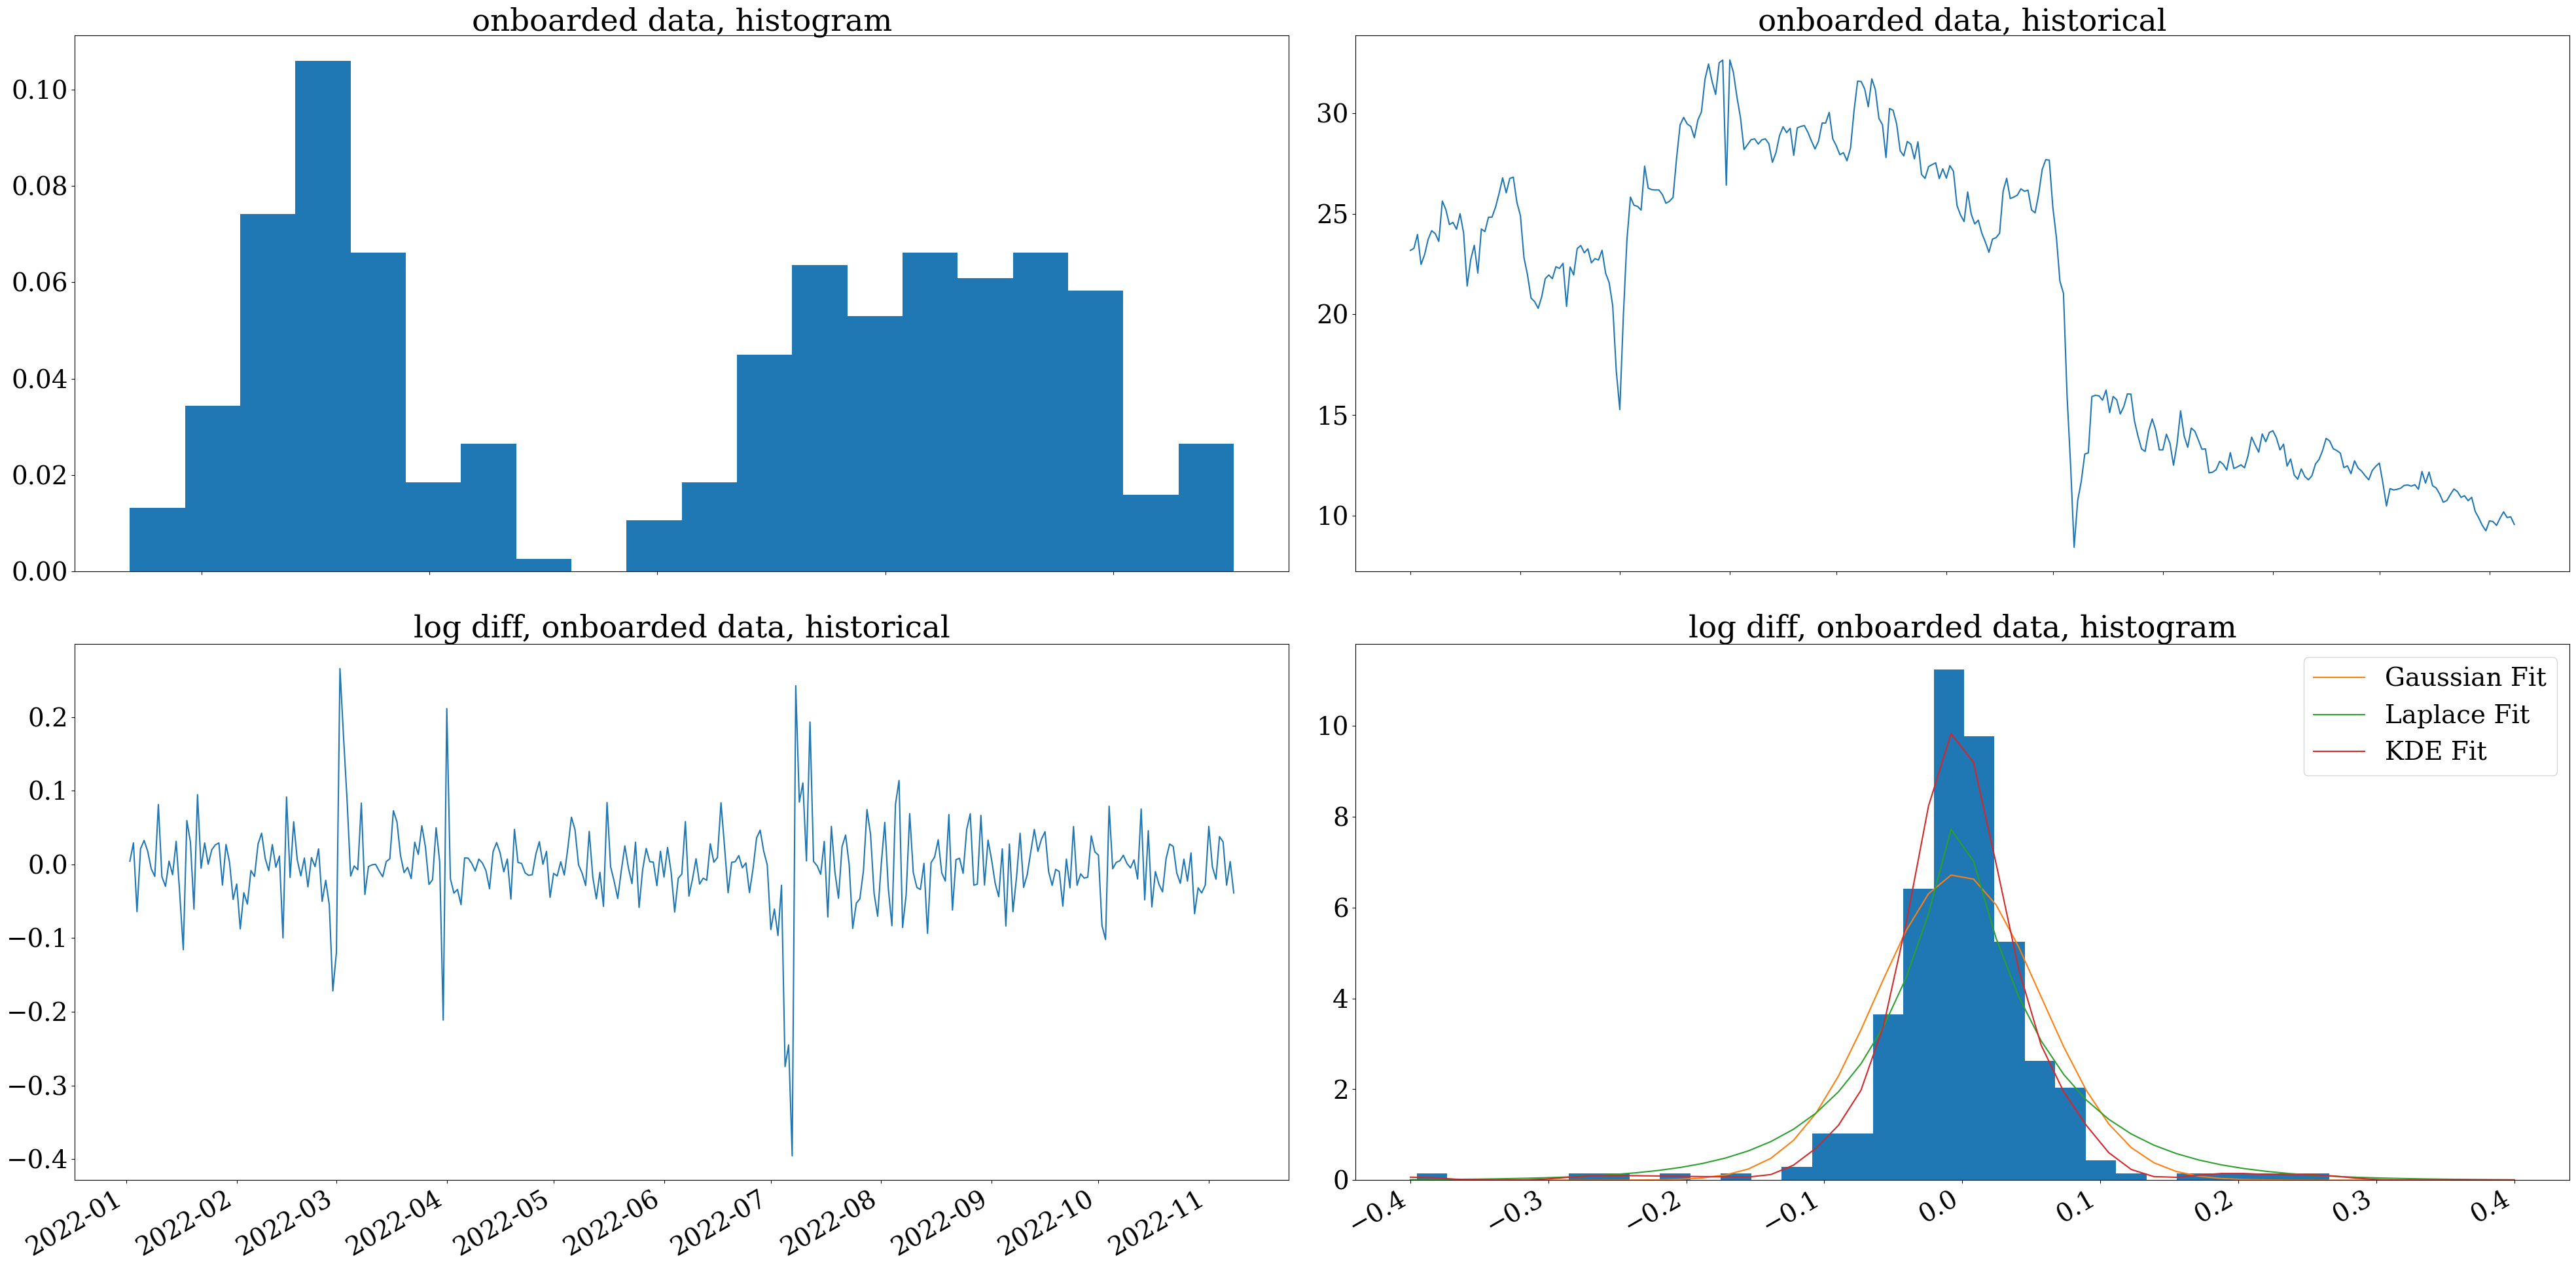

In [9]:
fig,ax=plt.subplots(2,2,figsize=(40,20))
ax[0,0].hist(df_ren['onboarded_bytes'],density=True,bins=20)
ax[0,0].set_title('onboarded data, histogram')
ax[0,0].set_xlabel('PiB')

ax[0,1].plot(df_ren['onboarded_bytes'])
ax[0,1].set_title('onboarded data, historical')

ax[1,0].plot(np.log(df_ren['onboarded_bytes']).diff())
ax[1,0].set_title('log diff, onboarded data, historical')

ax[1,1].hist(np.log(df_ren['onboarded_bytes']).diff(),density=True,bins=30)
ax[1,1].set_title('log diff, onboarded data, histogram')
mu=np.mean(np.log(df_ren['onboarded_bytes']).diff())
sig2=np.var(np.log(df_ren['onboarded_bytes']).diff())

normPdf =lambda x,mu,sig2: np.exp(-0.5*(x-mu)**2.0/sig2)/(2*np.pi*sig2)**0.5
LapPdf =lambda x,mu,sig2: 0.5*np.exp(-np.abs(x-mu)/sig2**0.5)/(sig2)**0.5
kde=stats.gaussian_kde(np.log(df_ren['onboarded_bytes']).diff().dropna())
xx=np.linspace(-0.4,0.4)
ax[1,1].plot(xx,normPdf(xx,mu,sig2),label='Gaussian Fit')
ax[1,1].plot(xx,LapPdf(xx,mu,sig2),label='Laplace Fit')
ax[1,1].plot(xx,kde.pdf(xx),label='KDE Fit')

plt.legend()

fig.autofmt_xdate()
plt.tight_layout()

From the previous figures, we can see that there was a big jump in onbaorded data, which results in a multi-modal distribution. Furthermore, defining $O_t$ as the onboarded data at time $t$, if we look at the time series and the histogram of $$\delta O_t^l:=\log\left( \frac{O_{t+1}}{O_t}  \right),$$

we can see that (1) such a time series seems to be sttionary and (2) the distribution of the relative increases seems to be fairly stable. Given this, and the fact that such a quantity should always be possitive, a simple model for $O_t$ could be of the form: 

\begin{aligned}
O_t&=O_0 e^{X^O_t},\\
X^O_t&=X^O_{t-1}+\xi_t^O\\
\xi^O_t&\overset{\text{iid}}{\sim} \text{KDE}(\delta O^l),
\end{aligned}

with $\text{KDE}(\delta O^l)$ defined as the Kernel Density Estimator (KDE) of $\delta O^l$ defined above. 

This gives simulated paths for onboarding as shown below.

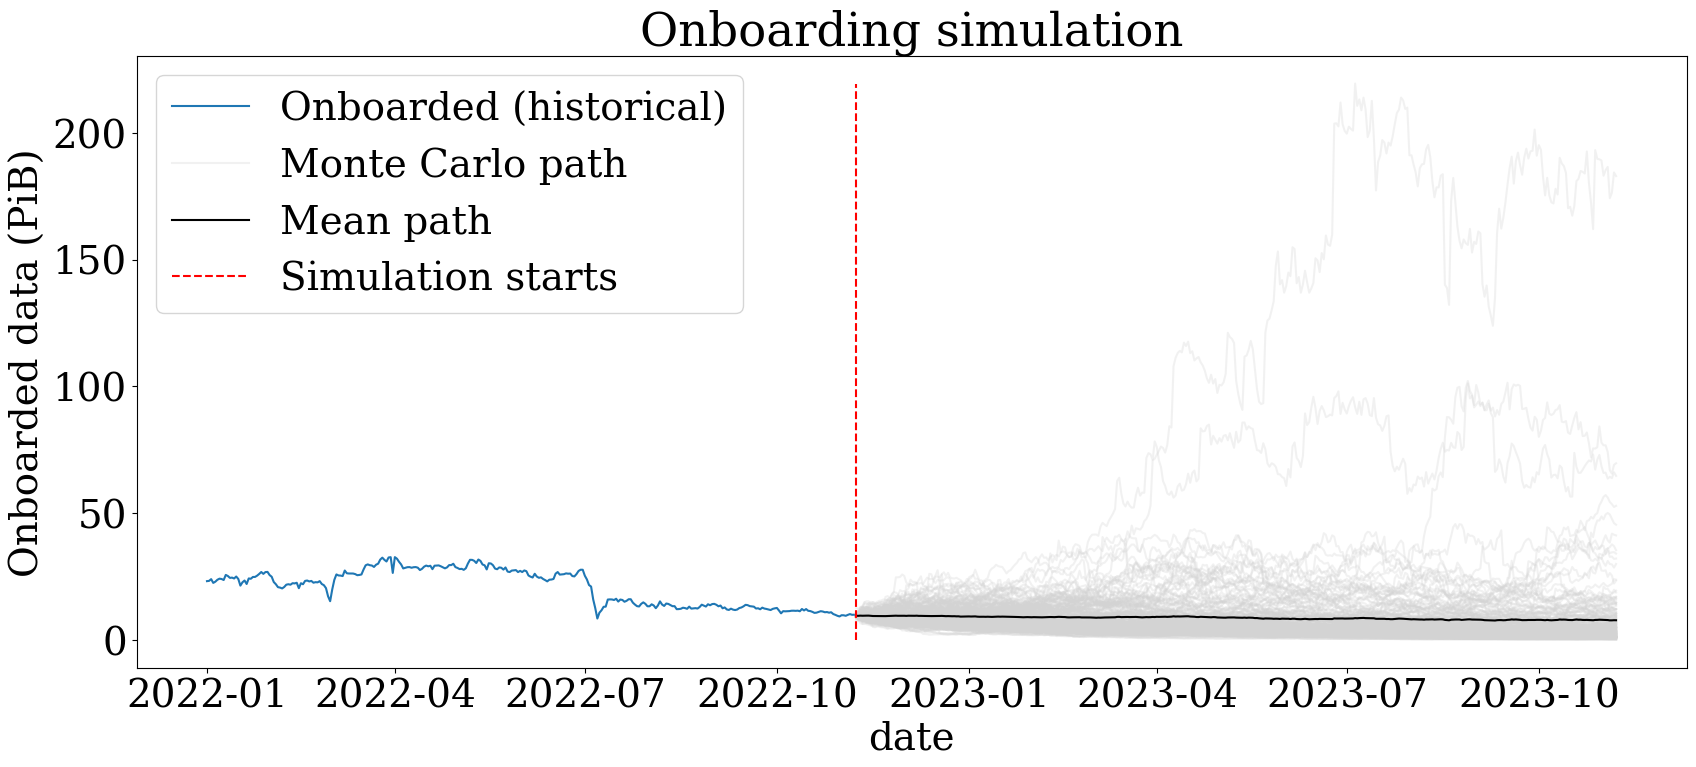

In [10]:
def simOnboard(Nsteps,KDE,O0):
    
    samples=KDE.resample(Nsteps)[0]
    logincr=np.cumsum(samples)
    oSim=O0*np.exp(logincr)
    return oSim
    


O0=df_ren['onboarded_bytes'].dropna().values[-1]
InitialDate=df_ren[df_ren['onboarded_bytes']==O0].values[0][0]
Nsims=200
Ndays=365
times=[InitialDate+datetime.timedelta(days=i) for i in range(Ndays)]

OS=[]
fig=plt.figure(figsize=(20,9))
fig.autofmt_xdate()

plt.plot(df_ren['onboarded_bytes'],label='Onboarded (historical)')
for i in range(Nsims):
    ss=simOnboard(Ndays,kde,O0)
    OS.append(ss)
    if i==0:
        plt.plot(times,ss,color='lightGray',alpha=0.3,label="Monte Carlo path")
    else:
        plt.plot(times,ss,color='lightGray',alpha=0.3)


m=np.mean(OS,axis=0)
plt.plot(times,m,color='black',label='Mean path')
plt.xlabel('date')
plt.ylabel('Onboarded data (PiB)')
plt.title('Onboarding simulation')
plt.vlines(x=InitialDate,ymin=0,ymax=np.max(OS),linestyles='dashed',color='red',label='Simulation starts')
plt.legend()

My intuition here is that one could use similar models for the other quantities. One would need to be careful, however, at estimating a covariance matrix across all these quantities, as they may or may not be independent. I know Kiran has done some work in coupling these sort of processes (see e.g., [Wikipedia page on copulas](https://en.wikipedia.org/wiki/Copula_(probability_theory)) )